#### Importing all the libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/kaggle/input/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

# for dirname, _, filenames in os.walk('/kaggle/input/liver-tumor-segmentation-part-2'):
#     for filename in filenames:
#         file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
166,/kaggle/input/liver-tumor-segmentation/volume_pt5,volume-50.nii
27,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-6.nii
30,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-7.nii
21,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-8.nii


##### Map CT scan and label 


In [4]:
df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files
#df_files_test

51


,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-11.nii,../input/liver-tumor-segmentation/segmentations,segmentation-11.nii
4,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-12.nii,../input/liver-tumor-segmentation/segmentations,segmentation-12.nii
5,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-13.nii,../input/liver-tumor-segmentation/segmentations,segmentation-13.nii
6,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-14.nii,../input/liver-tumor-segmentation/segmentations,segmentation-14.nii
7,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-15.nii,../input/liver-tumor-segmentation/segmentations,segmentation-15.nii
8,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-16.nii,../input/liver-tumor-segmentation/segmentations,segmentation-16.nii
9,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-17.nii,../input/liver-tumor-segmentation/segmentations,segmentation-17.nii


#### Reads .nii file and returns pixel array

In [5]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [6]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 75)
(512, 512, 75)
/kaggle/input/liver-tumor-segmentation/volume_pt1/volume-0.nii


In [7]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


#### Preprocess the nii file 

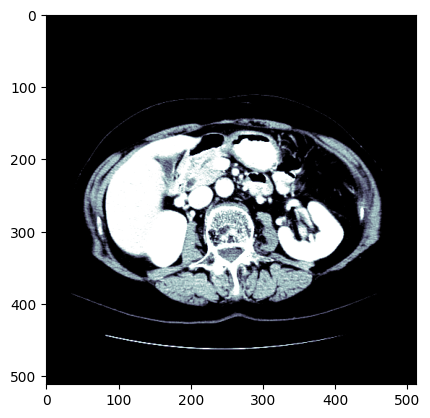

In [8]:
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

#### Plots and a slice with all available annotations

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

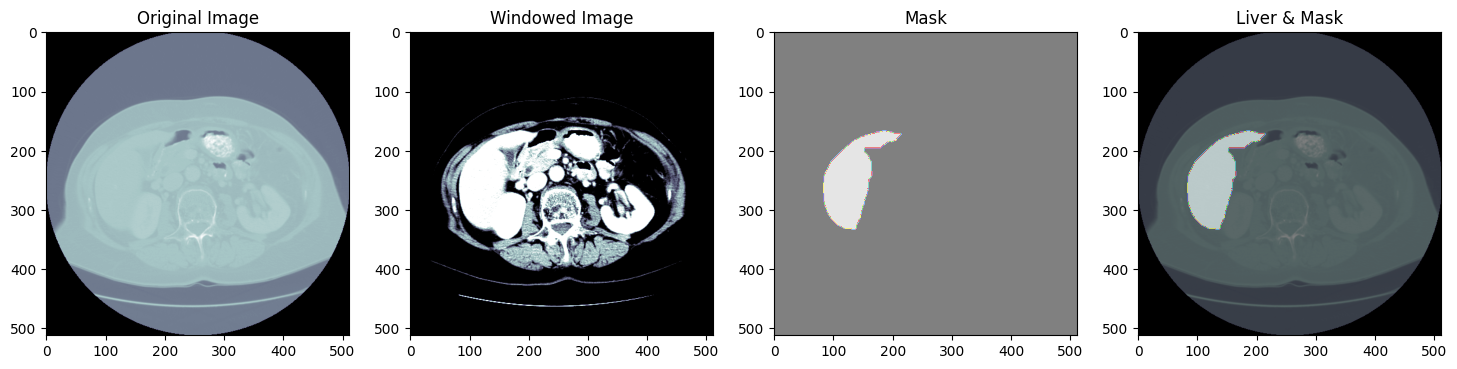

In [10]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [11]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


#### Preprocessing functions

<Axes: >

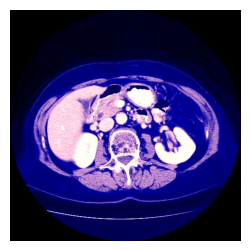

In [12]:

# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups, 
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [13]:
df_files_1=df_files[0:30]
df_files_1

,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-11.nii,../input/liver-tumor-segmentation/segmentations,segmentation-11.nii
4,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-12.nii,../input/liver-tumor-segmentation/segmentations,segmentation-12.nii
5,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-13.nii,../input/liver-tumor-segmentation/segmentations,segmentation-13.nii
6,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-14.nii,../input/liver-tumor-segmentation/segmentations,segmentation-14.nii
7,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-15.nii,../input/liver-tumor-segmentation/segmentations,segmentation-15.nii
8,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-16.nii,../input/liver-tumor-segmentation/segmentations,segmentation-16.nii
9,/kaggle/input/liver-tumor-segmentation/volume_pt2,volume-17.nii,../input/liver-tumor-segmentation/segmentations,segmentation-17.nii


In [14]:
import random

GENERATE_JPG_FILES = True   

if GENERATE_JPG_FILES:
    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    # Randomly select 1/3 of the indices
    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    for ii in tqdm(random_indices):  # take 1/3 nii files for training
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]  # 512, 512, curr_dim

        for curr_slice in range(0, curr_dim, 2):  # export every 2nd slice for training
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output


  0%|          | 0/25 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [18]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the directories
images_dir = 'train_images'
masks_dir = 'train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 3000)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

# Reshape masks to include a channel dimension
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))


#### Split the data into training, validation, and test sets
##### 70% training, 20% validation, 10% test

In [19]:

x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

In [20]:
x_train

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

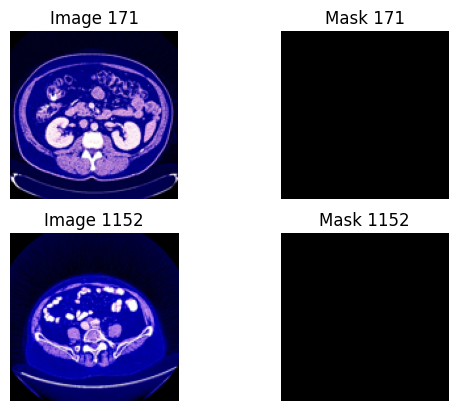

In [21]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select samples
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        # Display the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")

    plt.show()

# Display two random images and masks
display_images_and_masks(x_train, y_train)

In [22]:
y_train.shape, x_train.shape

((2100, 128, 128, 1), (2100, 128, 128, 3))

#### Building a model

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

def create_fcn_model(input_shape=(128, 128, 3), target_shape=(128, 128, 1)):
    model = keras.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder with Skip Connections
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))  # Assuming binary classification

    # Crop to match the target shape
    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model
# Create the FCN model
model = create_fcn_model()

# Display the model summary
model.summary()
model.save('fcn_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        

In [24]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [26]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model.compile(optimizer=Adam(lr=.001),loss='binary_crossentropy',
              metrics=[dice_coefficient])

In [27]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[reduce_lr,checkpoint])
model.save('fcn_model.h5')

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.4438 - dice_coefficient: 0.1155
Epoch 1: val_loss improved from inf to 3.73841, saving model to fcn_model.h5
132/132 [==============================] - 17s 59ms/step - loss: 0.4438 - dice_coefficient: 0.1155 - val_loss: 3.7384 - val_dice_coefficient: 0.0883 - lr: 0.0010
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.1671 - dice_coefficient: 0.2147
Epoch 2: val_loss improved from 3.73841 to 0.13564, saving model to fcn_model.h5
132/132 [==============================] - 6s 46ms/step - loss: 0.1671 - dice_coefficient: 0.2131 - val_loss: 0.1356 - val_dice_coefficient: 0.0333 - lr: 0.0010
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.0781 - dice_coefficient: 0.3413
Epoch 3: val_loss improved from 0.13564 to 0.12853, saving model to fcn_model.h5
132/132 [==============================] - 6s 46ms/step - loss: 0.0780 - dice_coefficient: 0.3421 - val_loss: 0.1285 - val_dice_c

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Accuracy

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience=3,
                                                save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=[Accuracy(), Precision()])


In [29]:
history = model.fit(x_train, y_train, epochs=5, batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[reduce_lr, checkpoint])


Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 9.1843e-05 - precision: 0.8669
Epoch 1: val_loss improved from inf to 0.05459, saving model to fcn_model.h5
132/132 [==============================] - 13s 52ms/step - loss: 0.0268 - accuracy: 9.1843e-05 - precision: 0.8669 - val_loss: 0.0546 - val_accuracy: 4.0690e-07 - val_precision: 0.8161 - lr: 0.0010
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 8.6195e-05 - precision: 0.8797
Epoch 2: val_loss improved from 0.05459 to 0.02927, saving model to fcn_model.h5
132/132 [==============================] - 6s 46ms/step - loss: 0.0203 - accuracy: 8.6031e-05 - precision: 0.8798 - val_loss: 0.0293 - val_accuracy: 1.1190e-06 - val_precision: 0.9291 - lr: 0.0010
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 1.1156e-04 - precision: 0.8787
Epoch 3: val_loss did not improve from 0.02927
132/132 [==============================] - 

In [30]:

# Save the model
model.save('fcn_model.h5')

# Access accuracy and precision from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']

print("Training Accuracy: ", train_accuracy)
print("Validation Accuracy: ", val_accuracy)
print("Training Precision: ", train_precision)
print("Validation Precision: ", val_precision)

Training Accuracy:  [9.184337977785617e-05, 8.603050810052082e-05, 0.00011134556552860886, 0.0001850527769420296, 0.0007005382794886827]
Validation Accuracy:  [4.0690105151952594e-07, 1.1189778206244227e-06, 6.001790552545572e-06, 0.004913330078125, 9.562174454913475e-06]
Training Precision:  [0.8669090867042542, 0.8797832131385803, 0.8777820467948914, 0.9016209244728088, 0.9112983345985413]
Validation Precision:  [0.816101610660553, 0.9290968179702759, 0.7765119671821594, 0.2824118435382843, 0.9002057313919067]


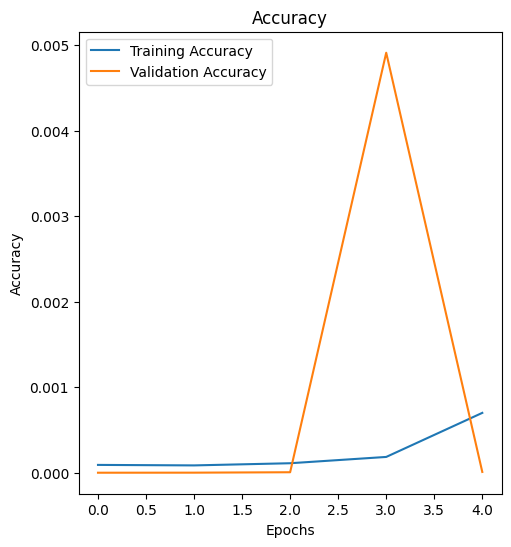

In [31]:

# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()





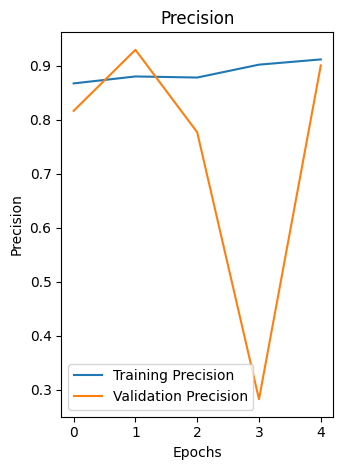

In [32]:
# Plotting precision
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

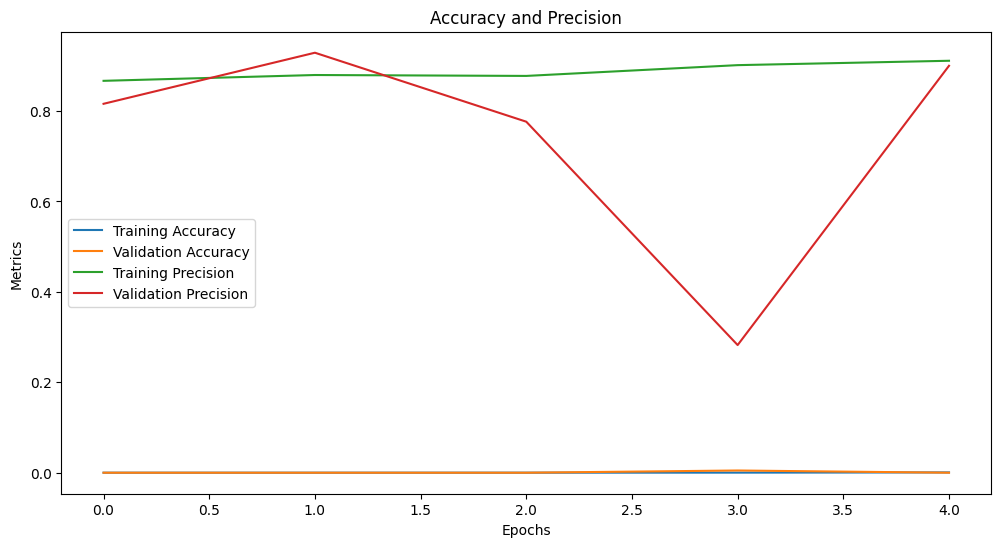

In [33]:
# Plotting both accuracy and precision in the same plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Accuracy and Precision')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


In [38]:
scores = model.evaluate(x_valid, y_valid)
scores[1]

19/19 [==============================] - 1s 26ms/step - loss: 0.0666 - accuracy: 4.0721e-04 - precision: 0.7705


0.00040720621473155916

#### Prediction

In [39]:
prediction = model.predict(x_test)
#print(prediction)
#print(y_test)

10/10 [==============================] - 0s 23ms/step


In [40]:
test_scores = model.evaluate(x_test, y_test)
test_scores[1]

10/10 [==============================] - 0s 24ms/step - loss: 0.0638 - accuracy: 2.6754e-04 - precision: 0.8096


0.0002675374271348119

1/1 [==============================] - 0s 396ms/step


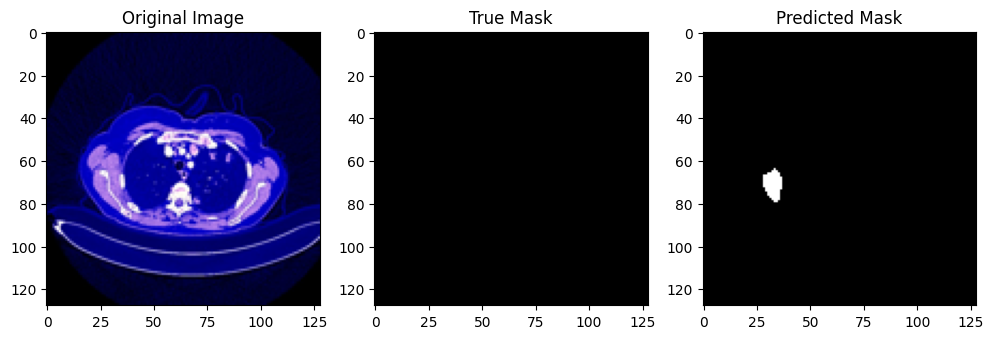

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 44

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


#### Building an Unet model

In [45]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define Dice coefficient as a metric
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2. * intersection + smooth) / (union + smooth)

# U-Net model architecture for liver segmentation
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)

    up5 = UpSampling2D(size=(2, 2))(merge4)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(merge5)

    model1 = Model(inputs=inputs, outputs=outputs)

    return model1

# Build the U-Net model
model1 = unet_model()

# Display the model summary
model1.summary()
model1.save('unetmodel.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_21[0][0]']           
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_22[0][0]']           
 g2D)                                                                                       

In [48]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, Precision
import matplotlib.pyplot as plt

# Define callbacks
checkpoint = ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience=3, 
                             save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=[Accuracy(), Precision()])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, 
                    validation_data=(x_valid, y_valid), 
                    callbacks=[reduce_lr, checkpoint, tensorboard_callback])

# Save the model
model.save('fcn_model.h5')




Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 8.4583e-04 - precision_2: 0.9143
Epoch 1: val_loss improved from inf to 0.02107, saving model to fcn_model.h5
132/132 [==============================] - 14s 57ms/step - loss: 0.0121 - accuracy: 8.4583e-04 - precision_2: 0.9143 - val_loss: 0.0211 - val_accuracy: 0.0021 - val_precision_2: 0.8186 - lr: 0.0010
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.0018 - precision_2: 0.9212
Epoch 2: val_loss did not improve from 0.02107
132/132 [==============================] - 7s 49ms/step - loss: 0.0112 - accuracy: 0.0018 - precision_2: 0.9211 - val_loss: 0.0315 - val_accuracy: 3.4800e-04 - val_precision_2: 0.8634 - lr: 0.0010
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.0025 - precision_2: 0.9286
Epoch 3: val_loss did not improve from 0.02107
132/132 [==============================] - 7s 49ms/step - loss: 0.0081 - accura

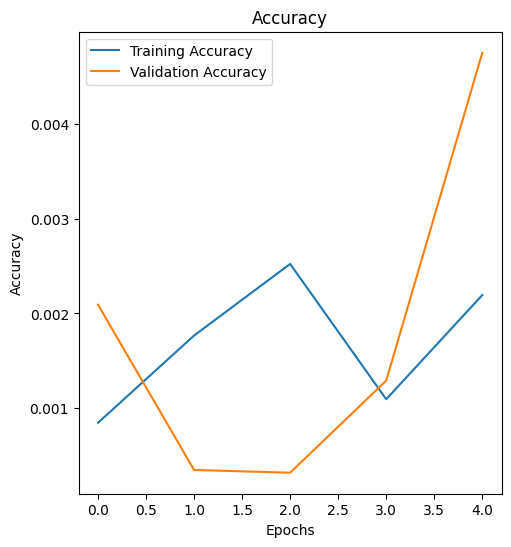

In [51]:
# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



#### Building Resnet model

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, Precision, MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [61]:
# Define Dice coefficient as a metric
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2. * intersection + smooth) / (union + smooth)

# Residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut if the number of filters has changed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# ResNet model architecture for liver segmentation
def resnet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Initial Convolution
    x = Conv2D(32, (7, 7), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 256)

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Adjust the final upsampling to match the input shape
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build the ResNet model
model = resnet_model()


In [62]:

# Display the model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_64 (Conv2D)          (None, 64, 64, 32)           4736      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_32 (Ba  (None, 64, 64, 32)           128       ['conv2d_64[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 64, 64, 32)           0         ['batch_normalization_32

In [63]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              loss='binary_crossentropy', 
              metrics=['accuracy', Precision()])

# Define callbacks
checkpoint = ModelCheckpoint("resnet_model.h5", monitor='val_loss', save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Assuming x_train, y_train, x_valid, y_valid are already defined

In [65]:
# Train the model
history = model.fit(x_train, y_train, epochs=6, batch_size=16, 
                    validation_data=(x_valid, y_valid), 
                    callbacks=[checkpoint, reduce_lr, tensorboard_callback])

# Save the model
model.save('resnet_models.h5')


Epoch 1/6
132/132 [==============================] - 3s 25ms/step - loss: 0.3525 - accuracy: 0.9809 - precision_5: 0.6128 - val_loss: 10.1560 - val_accuracy: 0.9418 - val_precision_5: 0.2450 - lr: 4.0000e-05
Epoch 2/6
132/132 [==============================] - 3s 22ms/step - loss: 0.5961 - accuracy: 0.9742 - precision_5: 0.4117 - val_loss: 3.8197 - val_accuracy: 0.9505 - val_precision_5: 0.0312 - lr: 4.0000e-05
Epoch 3/6
132/132 [==============================] - 3s 22ms/step - loss: 0.3185 - accuracy: 0.9822 - precision_5: 0.6372 - val_loss: 3.7153 - val_accuracy: 0.9755 - val_precision_5: 0.4753 - lr: 4.0000e-05
Epoch 4/6
132/132 [==============================] - 3s 22ms/step - loss: 0.1965 - accuracy: 0.9868 - precision_5: 0.7419 - val_loss: 3.4763 - val_accuracy: 0.9751 - val_precision_5: 0.4684 - lr: 4.0000e-05
Epoch 5/6
132/132 [==============================] - 3s 22ms/step - loss: 0.1346 - accuracy: 0.9870 - precision_5: 0.7464 - val_loss: 3.7929 - val_accuracy: 0.9738 - val_p

In [68]:
history

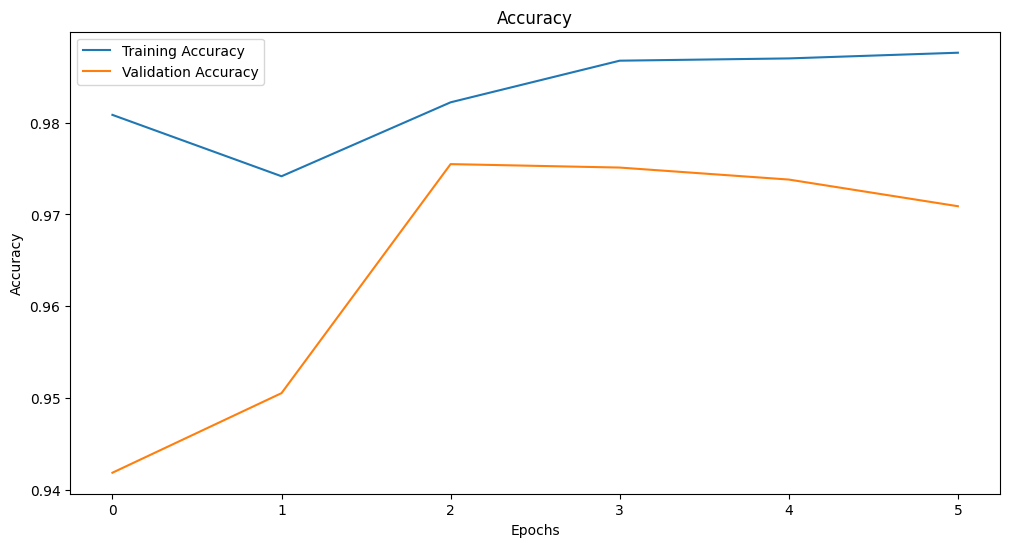

In [70]:
import matplotlib.pyplot as plt

# Extracting accuracy and precision from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history['precision_5']
val_precision = history.history['val_precision_5']

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


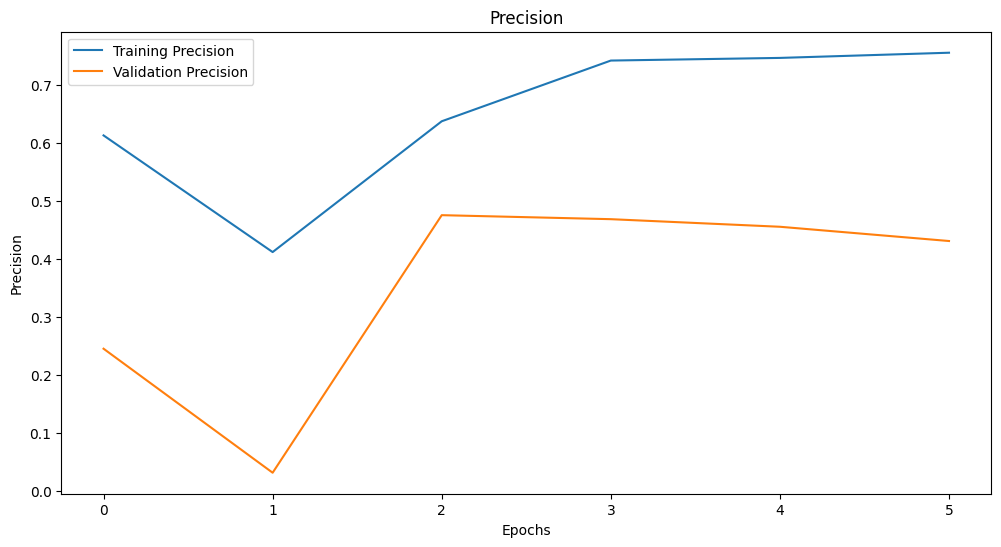

In [71]:

# Plotting precision
plt.figure(figsize=(12, 6))
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [73]:
scores1 = model.evaluate(x_valid, y_valid)
scores1[1]

19/19 [==============================] - 1s 29ms/step - loss: 12.1410 - accuracy: 0.9453 - precision_5: 0.2755


0.945317804813385

#### prediction on test data

In [76]:
prediction1 = model.predict(x_test)
# print(prediction)
print(y_test)

10/10 [==============================] - 0s 9ms/step
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 .

### taking the image and appling the prediction

In [78]:
test_scores1 = model.evaluate(x_test, y_test)
test_scores1[1]

10/10 [==============================] - 0s 11ms/step - loss: 9.2672 - accuracy: 0.9444 - precision_5: 0.2921


0.9443631768226624

In [81]:
model.save('resnet.h5')
